In [1]:
# import the modules that we need and specify the folder which contains the files
import pandas as pd
import glob, os
import mahotas as mh
import numpy as np
import matplotlib as mpl

from pylab import imshow
from skimage import io
import skimage
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

In [3]:
current_path = %pwd
% ls

MAX_stackwt1.tif  Untitled.ipynb    stackwt2.tif
MAX_stackwt2.tif  stackwt1.tif


In [8]:
image = io.imread(materials/'MAX_stackwt1.tif')
image.shape

(3, 1040, 1388, 3)

# This part read the Max image and parse out the blue and green channel #

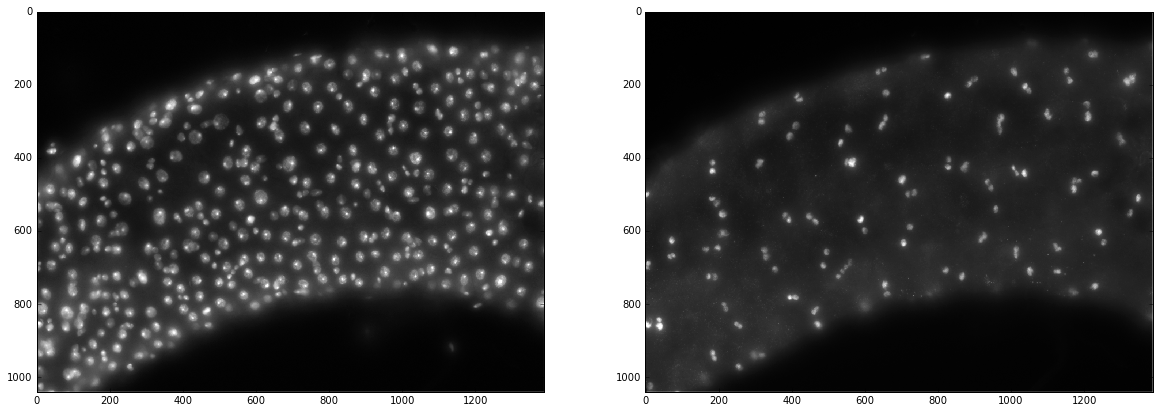

In [19]:
DNA = image[2, ..., 0]
green = image[1, ..., 0]

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 15))
ax1.imshow(DNA)
ax2.imshow(green)

# This is the previous approach to count the nuclei

However, this is not the best approach.

171


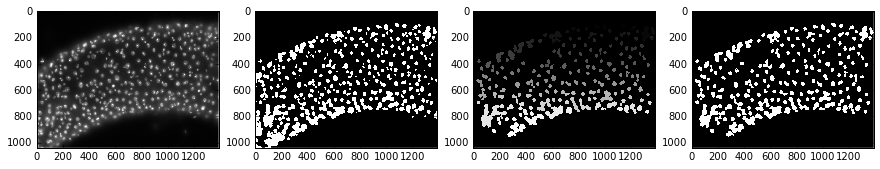

In [46]:
# DNAf = mh.gaussian_filter(DNA, 1)
DNAf = (DNA > mh.otsu(DNA) * 1.1)

labeled, numberOfNuclei = mh.label(DNAf)
original_label = labeled

max_size = 20000
min_size = 500

sizes = mh.labeled.labeled_size(labeled)

too_big = np.where(sizes > max_size)
labeled = mh.labeled.remove_regions(labeled, too_big)

too_small = np.where(sizes < min_size)
labeled = mh.labeled.remove_regions(labeled, too_small)

# Remove cells at the borders
labeled = mh.labeled.remove_bordering(labeled)

# Relabel everthing
relabeled, n_nuclei = mh.labeled.relabel(labeled)

relabeledf = (relabeled > 0)

fig, (ax_original, ax_filter, ax_label, ax_relabel) = plt.subplots(ncols = 4, figsize = (15,10))
ax_original.imshow(DNA, cmap = 'gray')
ax_filter.imshow(DNAf, cmap = 'gray')
ax_label.imshow(relabeled)
ax_relabel.imshow(relabeledf)
print(n_nuclei)

# Blob detection of nuclei

Since we do not need to measure the size of each nuclei, I believe that using blob detecting is better for counting.
Notice that the ** 'Laplacian of Gaussian' ** seems to be the best way.

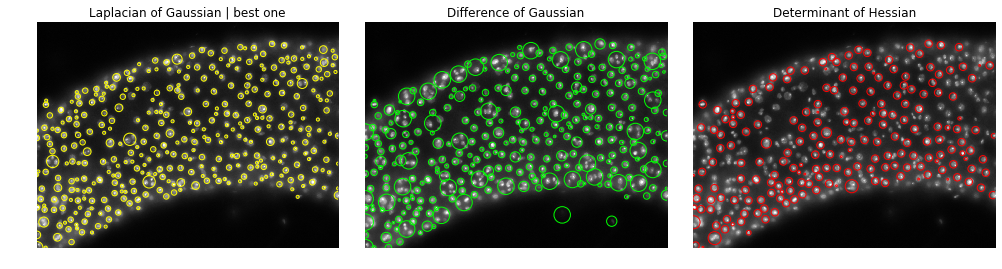

In [65]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray

blobs_log = blob_log(DNA, max_sigma=20, min_sigma = 5, num_sigma=5, overlap = 0.1, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(DNA, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(DNA, max_sigma=30, threshold=.005)
blobs_list = [blobs_log, blobs_dog, blobs_doh]

colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian | best one', 'Difference of Gaussian',
          'Determinant of Hessian']

sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plt.tight_layout()

axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(DNA, interpolation='nearest')
    ax.set_axis_off()
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)


In [62]:
print('The number of nuclei counted is ' + str(len(blobs_log)))

The number of nuclei counted is 368


** my manu count is 364**, not bad.

# The next part is counting the green dots.
again, 'Laplacian of Gaussian' seems to be the best way.

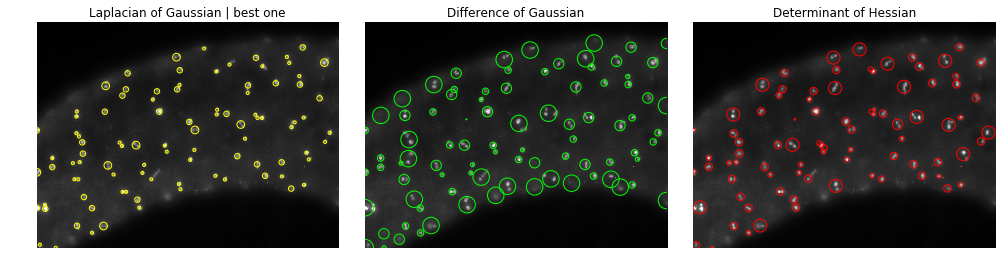

In [66]:
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray

blobs_log = blob_log(green, max_sigma=20, min_sigma = 5, num_sigma=5, overlap = 0.1, threshold=.1)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(green, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(green, max_sigma=30, threshold=.001)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian | best one', 'Difference of Gaussian',
          'Determinant of Hessian']

sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
plt.tight_layout()

axes = axes.ravel()
for blobs, color, title in sequence:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title(title)
    ax.imshow(green, interpolation='nearest')
    ax.set_axis_off()
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)


In [64]:
print('The number of green dots is ' + str(len(blobs_log)))

The number of green dots is 368


my ** manu count is 107**, again, not bad

*Overall, I am happy with the Laplacian of Gaussian blob detection right now.*